In [3]:
# -*- coding: utf-8 -*-
# Adapted from 2017 Interstellar Technologies Inc. All Rights Reserved.

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics
from math import *

from scipy import integrate
from scipy import interpolate

class Orbiter:
    def __init__(self):
        
        #note, if d_ is used, it refers to dimensional quantity in SI units. 
        
        AU = 1.5*10**11;
        mu_sun = (6.67*10**-11)*(2*10**30) #SI units
        mu_earth = (6.67*10**-11)*(5.97*10**24)
        year = 3.154*10**7 #seconds
        self.year = year;
        #set up non-d params
        
        self.lref = 1*AU; #1 AU
        self.vref = sqrt(mu_sun/self.lref) #v of earths orbit
        self.tref = self.lref/self.vref
        self.aref = (self.vref)**2/self.lref
        self.wref = 1/self.tref;
        
        
        self.d_mdry = 2800; #kg
        
        #assign operating limits
        self.d_a_max = 0.5/self.d_mdry; #assuming 0.5N for vehicle mass of 5000 kg
        
        self.d_tf_max = 15*year;
        
        
        #assign initial conditions
        self.d_r0 = 1*AU;
        self.d_vr0 = 0;
        self.d_vt0 = sqrt(mu_sun/(1*AU));
        self.d_w0 =self.d_vt0/self.d_r0; #earths orbital speed
        
        
        #final conditions
        self.d_rf = 9.6*AU;
        self.d_vrf = 0;
        self.d_final_apogee = 9.6*AU;
        self.d_final_semimajor = (self.d_rf+self.d_final_apogee)/2;        
        self.d_vtf = sqrt(mu_sun*(2/self.d_rf - 1/self.d_final_semimajor)); #vis viva equation at venus apogee.
        self.d_wf = self.d_vtf/self.d_rf;
        self.d_saturndvMax = 500; #m/s
        
        #max vinf at earth
        earthR = 6371*1000;
        closestApproach = earthR + 1500*1000; #cassini did 1172km
        self.d_maxvinf_at_earth = (mu_earth/closestApproach)**0.5
        
        #non-dimensionalise
        self.u_max  = self.d_a_max/self.aref;
        self.r0     = self.d_r0 /self.lref;
        self.vr0    = self.d_vr0/self.vref;
        self.vt0    = self.d_vt0/self.vref;
        self.w0     = self.d_w0/self.wref;
        self.rf     = self.d_rf /self.lref;
        self.vrf    = self.d_vrf/self.vref;
        self.vtf    = self.d_vtf/self.vref;
        self.SdvMax = self.d_saturndvMax/self.vref;
        self.tf_max = self.d_tf_max/self.tref;
        self.maxvinf_at_earth = self.d_maxvinf_at_earth/self.vref;


def dynamics(prob, obj, section):
    r   = prob.states(0, section)
    vr  = prob.states(1, section)
    vt  = prob.states(2, section)
    ur1 = prob.controls(0, section)
    ur2 = prob.controls(1, section)
    ut1 = prob.controls(2, section)
    ut2 = prob.controls(3, section)

    dx = Dynamics(prob, section)
    dx[0] = vr
    dx[1] = vt**2 / r - 1 / r**2 + (ur1 - ur2)
    dx[2] = - vr * vt / r + (ut1 - ut2)
    return dx()


def equality(prob, obj):
    r   = prob.states_all_section(0)
    vr  = prob.states_all_section(1)
    vt  = prob.states_all_section(2)
    ur1 = prob.controls_all_section(0)
    ur2 = prob.controls_all_section(1)
    ut1 = prob.controls_all_section(2)
    ut2 = prob.controls_all_section(3)

    #1 is EE
    #2 is Ejettison
    #3 is jettisonS
    
    r1  = prob.states(0,0)
    vr1 = prob.states(1,0)
    vt1 = prob.states(2,0)
    
    r2  = prob.states(0,1)
    vr2 = prob.states(1,1)
    vt2 = prob.states(2,1)
    
    r3  = prob.states(0,2)
    vr3 = prob.states(1,2)
    vt3 = prob.states(2,2)
    
    tf  = prob.time_final(-1)

    result = Condition()

    # start conditions
    result.equal(r[0], obj.r0)
    result.equal(vr[0], obj.vr0)
    result.equal(vt[0], obj.vt0)

    #end conditions
    result.equal(r[-1], obj.rf)
    
    #no thurst during the 3rd phase
    result.equal(prob.controls(0,2),0)
    result.equal(prob.controls(1,2),0)
    result.equal(prob.controls(2,2),0)
    result.equal(prob.controls(3,2),0)
    
    
    #require flyby to occur at earth
    result.equal(r1[-1], 1) #location
    
    #time is such that the earth has moved the right amount
    time1 = (prob.time)[0]
    theta_satellite = integrate.cumtrapz(vt1 / r1, time1, initial=0)
    theta_earth = obj.w0*time1[-1];
    #result.equal(theta_satellite,theta_earth)
    #result.equal(prob.time_final(0)%obj.year,0) #time must be integral interval of a year
    
    #flyby condition on velocity
    #vtearth = 1;
    vinf1 = ( (vr1[-1])**2 + (vt1[-1]-1)**2 )**0.5 # inbound vinf
    vinf2 = ( (vr2[0] )**2 + (vt2[0] -1)**2 )**0.5 #outbound vinf
    result.equal(vinf1,vinf2)
    
    
    
    
    #knotting condition
    #phase 1 to 2, fly by delta v
    result.equal(r1[-1],r2[0])
    
    #phase 2 and 3
    result.equal(r2[-1],r3[0])
    result.equal(vr2[-1],vr3[0])
    result.equal(vt2[-1],vt3[0])
    

    return result()


def inequality(prob, obj):
    r   = prob.states_all_section(0)
    vr  = prob.states_all_section(1)
    vt  = prob.states_all_section(2)
    ur1 = prob.controls_all_section(0)
    ur2 = prob.controls_all_section(1)
    ut1 = prob.controls_all_section(2)
    ut2 = prob.controls_all_section(3)
    tf  = prob.time_final(-1)
    
    r1  = prob.states(0,0)
    vr1 = prob.states(1,0)
    vt1 = prob.states(2,0)
    
    r2  = prob.states(0,1)
    vr2 = prob.states(1,1)
    vt2 = prob.states(2,1)
    
    r3  = prob.states(0,2)
    vr3 = prob.states(1,2)
    vt3 = prob.states(2,2)
    
    result = Condition()

    # lower bounds
    result.lower_bound(r, 0.5*min(obj.r0,obj.rf))
    result.lower_bound(ur1, 0.0)
    result.lower_bound(ut1, 0.0)
    result.lower_bound(ur2, 0.0)
    result.lower_bound(ut2, 0.0)
    result.lower_bound(tf, 0.0)
    

    # upper bounds
    result.upper_bound(r, 1.3*max(obj.r0,obj.rf))
    result.upper_bound(tf, obj.tf_max)
    result.upper_bound(np.sqrt(np.square(ur1-ur2) + np.square(ut1-ut2)), obj.u_max)

    
    #termination
    saturndv = ((vr[-1])**2 + (vt[-1]-obj.vtf)**2)**0.5
    result.lower_bound(saturndv,0)
    result.upper_bound(saturndv,+obj.SdvMax)
    
    
    #flyby condition on velocity
    #vtearth = 1;
    
    vinf1 = ( (vr1[-1])**2 + (vt1[-1]-1)**2 )**0.5 # inbound vinf
    vinf2 = ( (vr2[0] )**2 + (vt2[0] -1)**2 )**0.5 #outbound vinf
    
    #result.lower_bound(vinf1,0)
    #result.upper_bound(vinf1,obj.maxvinf_at_earth)
        

    return result()


def cost(prob, obj):
    return 0.0


def running_cost(prob, obj):
    ur1 = prob.controls_all_section(0)
    ur2 = prob.controls_all_section(1)
    ut1 = prob.controls_all_section(2)
    ut2 = prob.controls_all_section(3)
    
    netaccel = np.sqrt(np.square(ur1 + ur2) + np.square(ut1 + ut2));
    
    if 0:
        print(type(ur1))
        print(ur1.size)
        print((ur1+ur2+ut1+ut2).size)
        print(netaccel.size)
    
    

    return netaccel



In [4]:
obj=Orbiter()
print(obj.d_maxvinf_at_earth)

7112.710398902147


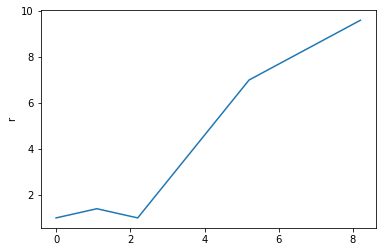

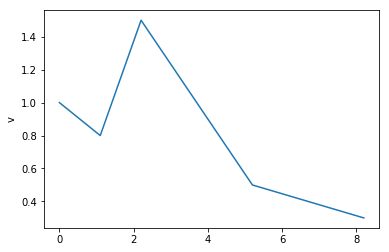

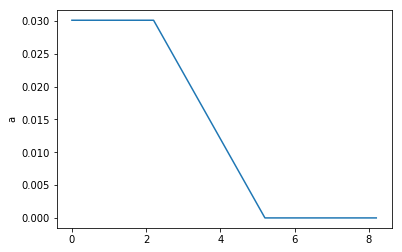

In [5]:

# ========================
plt.close("all")
plt.ion()
# Program Starting Point

obj = Orbiter()

time_init_years = [0, 2.2, (2.2+3), (2.2+3+3)]
time_init = [t*obj.year/obj.tref for t in time_init_years]
n = [100,100,100]
num_states = [3,3,3]
num_controls = [4,4,4]
max_iteration = 2

flag_savefig = False

savefig_dir = "10_Low_Thrust_Orbit_Transfer/"

# ------------------------
# set OpenGoddard class for algorithm determination
prob = Problem(time_init, n, num_states, num_controls, max_iteration)


# ========================
# Initial parameter guess
t_guess  =                       [0, 1.1, 2.2, 5.2, 8.2]
r_guess  = [r*obj.r0    for r in [1, 1.4, 1.0, 7, 9.6]]
v_guess  = [v*obj.vt0   for v in [1, 0.8, 1.5, 0.5, 0.3]]
ut_guess = [u*obj.u_max for u in [1, 1  , 1  , 0  , 0  ]]



# Guess.plot(prob.time_all_section, r_init, "r", "time", "r")
# if(flag_savefig):plt.savefig(savefig_dir + "guess_r" + savefig_add + ".png")

# vr_init = Guess.linear(prob.time_all_section, obj.vr0, obj.vrf)
# Guess.plot(prob.time_all_section, vr_init, "vr", "time", "vr")
# if(flag_savefig):plt.savefig(savefig_dir + "guess_vr" + savefig_add + ".png")

# vt_init = Guess.linear(prob.time_all_section, obj.vt0, obj.vtf)
# Guess.plot(prob.time_all_section, vt_init, "vt", "time", "vt")
# if(flag_savefig):plt.savefig(savefig_dir + "guess_vt" + savefig_add + ".png")

# ur1_init = Guess.linear(prob.time_all_section, obj.u_max, obj.u_max)
# Guess.plot(prob.time_all_section, ur1_init, "ur1", "time", "ur1")
# if(flag_savefig):plt.savefig(savefig_dir + "guess_ur1" + savefig_add + ".png")

# ut1_init = Guess.linear(prob.time_all_section, obj.u_max, obj.u_max)
# Guess.plot(prob.time_all_section, ut1_init, "ut1", "time", "ut1")
# if(flag_savefig):plt.savefig(savefig_dir + "guess_ut1" + savefig_add + ".png")

plt.figure()
plt.plot(t_guess,r_guess)
plt.ylabel('r')
plt.figure()
plt.plot(t_guess,v_guess)
plt.ylabel('v')
plt.figure()
plt.plot(t_guess,ut_guess)
plt.ylabel('a');

In [7]:

#prob.set_states_all_section(0, r_init)
#prob.set_states_all_section(1, vr_init)
#prob.set_states_all_section(2, vt_init)
#prob.set_controls_all_section(0, ur1_init)
#prob.set_controls_all_section(2, ut1_init)


t_guess_f = prob.time_all_section;

r_interp = interpolate.interp1d(t_guess,r_guess)
v_interp = interpolate.interp1d(t_guess,v_guess)
ut_interp = interpolate.interp1d(t_guess,ut_guess)


prob.set_states_all_section(0,r_interp(t_guess_f*obj.tref/obj.year))
prob.set_states_all_section(1,np.array([0]*len(t_guess_f)))
prob.set_states_all_section(2,v_interp(t_guess_f*obj.tref/obj.year))

prob.set_controls_all_section(2,ut_interp(t_guess_f*obj.tref/obj.year))
prob.set_controls_all_section(0, np.array([0]*len(t_guess_f)))
prob.set_controls_all_section(1, np.array([0]*len(t_guess_f)))
prob.set_controls_all_section(3, np.array([0]*len(t_guess_f)))


# ========================
# Main Process
# Assign problem to SQP solver
prob.dynamics = [dynamics,dynamics,dynamics]
prob.knot_states_smooth = [False,True]
prob.cost = cost
prob.running_cost = running_cost
prob.equality = equality
prob.inequality = inequality


def display_func():
    tf = prob.time_final(-1)
    print("tf: {0:.5f}".format(tf))
    


prob.solve(obj, display_func, ftol=1e-2)


---- iteration : 1 ----
More than 3*n iterations in LSQ subproblem    (Exit mode 3)
            Current function value: 749466.1600513845
            Iterations: 7
            Function evaluations: 14738
            Gradient evaluations: 7
More than 3*n iterations in LSQ subproblem
tf: 75.00133

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 752625.5210671603
            Iterations: 26
            Function evaluations: 54752
            Gradient evaluations: 26
Iteration limit exceeded
tf: 94.05291



/Users/Devansh/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


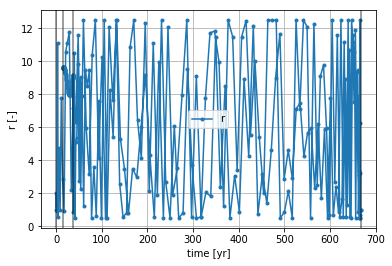

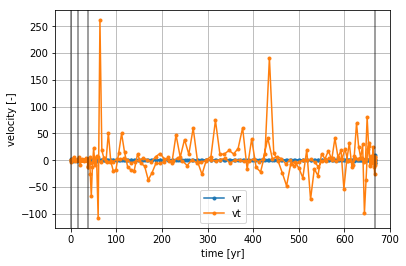

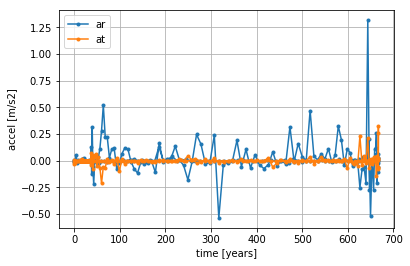

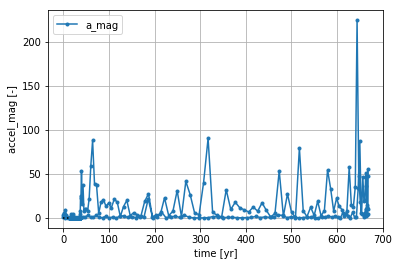

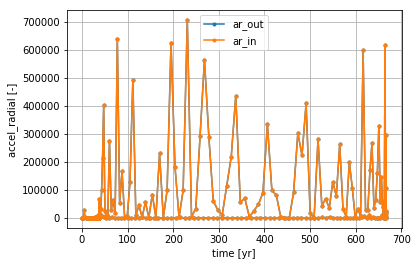

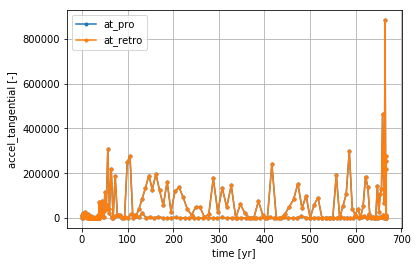

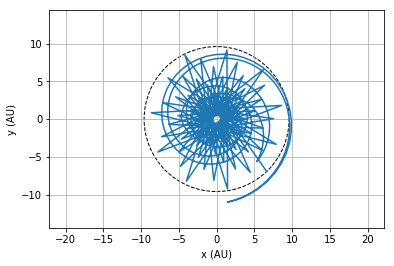

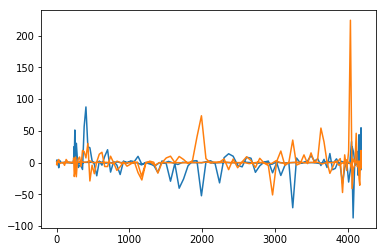

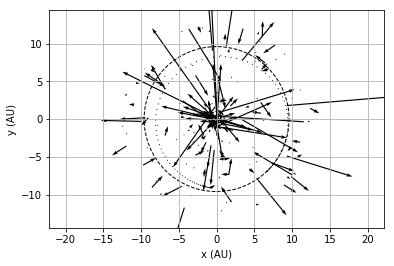

In [8]:

# ========================
# Post Process
# ------------------------
# Convert parameter vector to variable
r = prob.states_all_section(0)
vr = prob.states_all_section(1)
vt = prob.states_all_section(2)
ur1 = prob.controls_all_section(0)
ur2 = prob.controls_all_section(1)
ut1 = prob.controls_all_section(2)
ut2 = prob.controls_all_section(3)
time = prob.time_update()

year = 3.154*10**7 #seconds

accel_mag=np.sqrt(np.square(ur1-ur2)+np.square(ut1-ut2))



# ------------------------
# Visualization
plt.figure()
plt.plot(time*obj.tref/year, r, marker=".", label="r")
for line in prob.time_knots():
    plt.axvline(line*obj.tref/year, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("r [-]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_dir + "r" + ".png")

plt.figure()
plt.plot(time*obj.tref/year, vr, marker=".", label="vr")
plt.plot(time*obj.tref/year, vt, marker=".", label="vt")
for line in prob.time_knots():
    plt.axvline(line*obj.tref/year, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("velocity [-]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_dir + "velocity" + ".png")

plt.figure()
plt.plot(time*obj.tref/year, (ur1 - ur2)*obj.aref, marker=".", label="ar")
plt.plot(time*obj.tref/year, (ut1 - ut2)*obj.aref, marker=".", label="at")
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("accel [m/s2]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, accel_mag, marker=".", label="a_mag")
plt.plot([0,time[-1]*obj.tref/year],[obj.u_max,obj.u_max],'k:')
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("accel_mag [-]")
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, ur1, marker=".", label="ar_out")
plt.plot(time*obj.tref/year, ur2, marker=".", label="ar_in")
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("accel_radial [-]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, ut1, marker=".", label="at_pro")
plt.plot(time*obj.tref/year, ut2, marker=".", label="at_retro")
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("accel_tangential [-]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

if(flag_savefig): plt.savefig(savefig_dir + "thrust" + ".png")


from scipy import integrate
from scipy import interpolate

theta = integrate.cumtrapz(vt / r, time, initial=0)
theta_f = interpolate.interp1d(time, theta)
r_f = interpolate.interp1d(time, r)
time_fine = np.linspace(time[0], time[-1], 1000)
r_fine = r_f(time_fine)
theta_fine = theta_f(time_fine)

fig = plt.figure()
# plt.plot(r*np.cos(theta), r*np.sin(theta))
plt.plot(r_fine*np.cos(theta_fine), r_fine*np.sin(theta_fine))
ax = fig.add_subplot(111)
circle0 = plt.Circle((0.0, 0.0), obj.r0, ls="--", fill=False, fc='none')
circlef = plt.Circle((0.0, 0.0), obj.rf, ls="--", fill=False, fc='none')
ax.add_patch(circle0)
ax.add_patch(circlef)
plt.grid()
plt.axis('equal')
plt.ylim((-1.5*max(obj.r0,obj.rf),1.5*max(obj.r0,obj.rf)))
plt.xlim((-1.5*max(obj.r0,obj.rf),1.5*max(obj.r0,obj.rf)))
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
if(flag_savefig): plt.savefig(savefig_dir + "trajectry" + ".png")


plt.show()


#plot the burn direction vector

helioxaccel = (ur1 - ur2)*np.cos(theta) - (ut1-ut2)*np.sin(theta)
helioyaccel = (ur1 - ur2)*np.sin(theta) + (ut1-ut2)*np.cos(theta)

fig = plt.figure()
plt.plot(time,helioxaccel,label='helio x')
plt.plot(time,helioyaccel, label='helio y')

plt.show()

fig = plt.figure()
# plt.plot(r*np.cos(theta), r*np.sin(theta))
plt.quiver(r*np.cos(theta), r*np.sin(theta), helioxaccel,helioyaccel)
ax = fig.add_subplot(111)
circle0 = plt.Circle((0.0, 0.0), obj.r0, ls="--", fill=False, fc='none')
circlef = plt.Circle((0.0, 0.0), obj.rf, ls="--", fill=False, fc='none')
ax.add_patch(circle0)
ax.add_patch(circlef)
plt.grid()
plt.axis('equal')
plt.ylim((-1.5*max(obj.r0,obj.rf),1.5*max(obj.r0,obj.rf)))
plt.xlim((-1.5*max(obj.r0,obj.rf),1.5*max(obj.r0,obj.rf)))
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
if(flag_savefig): plt.savefig(savefig_dir + "trajectry" + ".png")


plt.show()

In [ ]:
prob.time_update()

In [ ]:
plt.figure()
plt.plot(time)

In [ ]:
len(ur2)

In [ ]:
len(theta)

In [ ]:
plt.figure()
plt.plot(time_fine*obj.tref/year,360*((theta_fine/(2*pi))%1))
plt.grid()

In [ ]:
#determine how long the transfer will take
final_time = time[-1]
d_final_time = final_time*obj.tref
year = 3.154*10**7 #seconds

print("Transfer time: ",d_final_time/year, "years")

#determine delta v and mass fraction
delv=np.trapz(y=accel_mag,x=time)
d_delv = delv*obj.vref
print("Required Delta-v: ", d_delv, "m/s")
mpm0=1-exp(-d_delv/(2020*9.81))
print("Propellant mass fraction: ", mpm0)

#final phase angle:
print("Arriving phase: ", theta_fine[-1], "rad")
print("Arriving phase: ", 360*((theta_fine[-1]/(2*pi))%1))

In [ ]:
#integrate the dynamics from the end point

#define the passive dynamics
from scipy.integrate import odeint
def passiveDynamics(x,t):
    r = x[0]
    vr = x[1]
    vt = x[2]
    
    dx = [0,0,0]
    dx[0] = vr
    dx[1] = vt**2 / r - 1 / r**2
    dx[2] = - vr * vt / r
    
    return dx

#integrate using odeint
t_passive = np.linspace(final_time,final_time+2*year/obj.tref,10000)
x_passive = odeint(passiveDynamics,[r[-1],vr[-1],vt[-1]],t_passive)

#extract the radial position
r_passive = x_passive[:,0]


#plot the final solution
plt.figure()
plt.plot(time*obj.tref/year, r,'b')
plt.plot(t_passive*obj.tref/year, r_passive,'r')
plt.plot([0,final_time*obj.tref/year + 2],[obj.r0,obj.r0],'k:')
plt.plot([0,final_time*obj.tref/year + 2],[obj.rf,obj.rf],'k:')
plt.plot([0,final_time*obj.tref/year + 2],[obj.d_final_apogee/obj.lref,obj.d_final_apogee/obj.lref],'k:')
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("radius [AU]")

plt.show()

